#### 通过主成分分析进行无监督降维

关于特征选择和特征提取的区别：

* 特征选择：获取或者保留的是原始特征集合的一个子集，仍然是"original features"；
* 特征提取：是将待处理的数据集投影到一个新的特征空间。

特征提取可以理解为一种数据压缩方法，目的是保留大部分相关信息。在实践中，特征提取不仅用于改善存储空间或者学习算法的计算效率，还可以通过缓解维数灾难(curse of dimensionality)来提高预测性能，尤其是在使用正则化模型时。

#### 主成分分析(Principal component analysis, PCA)的主要步骤

无监督(unsupervised)的主成分分析方法, 帮助我们根据特征之间的相关性识别数据模式。简言之，PCA旨在找到高维数据中方差最大的方向，并将数据投影到与原始特征空间相同或更少的子空间上。

如下图所示，在新的特征轴相互正交的约束下，主成分可以理解为方差最大的方向：

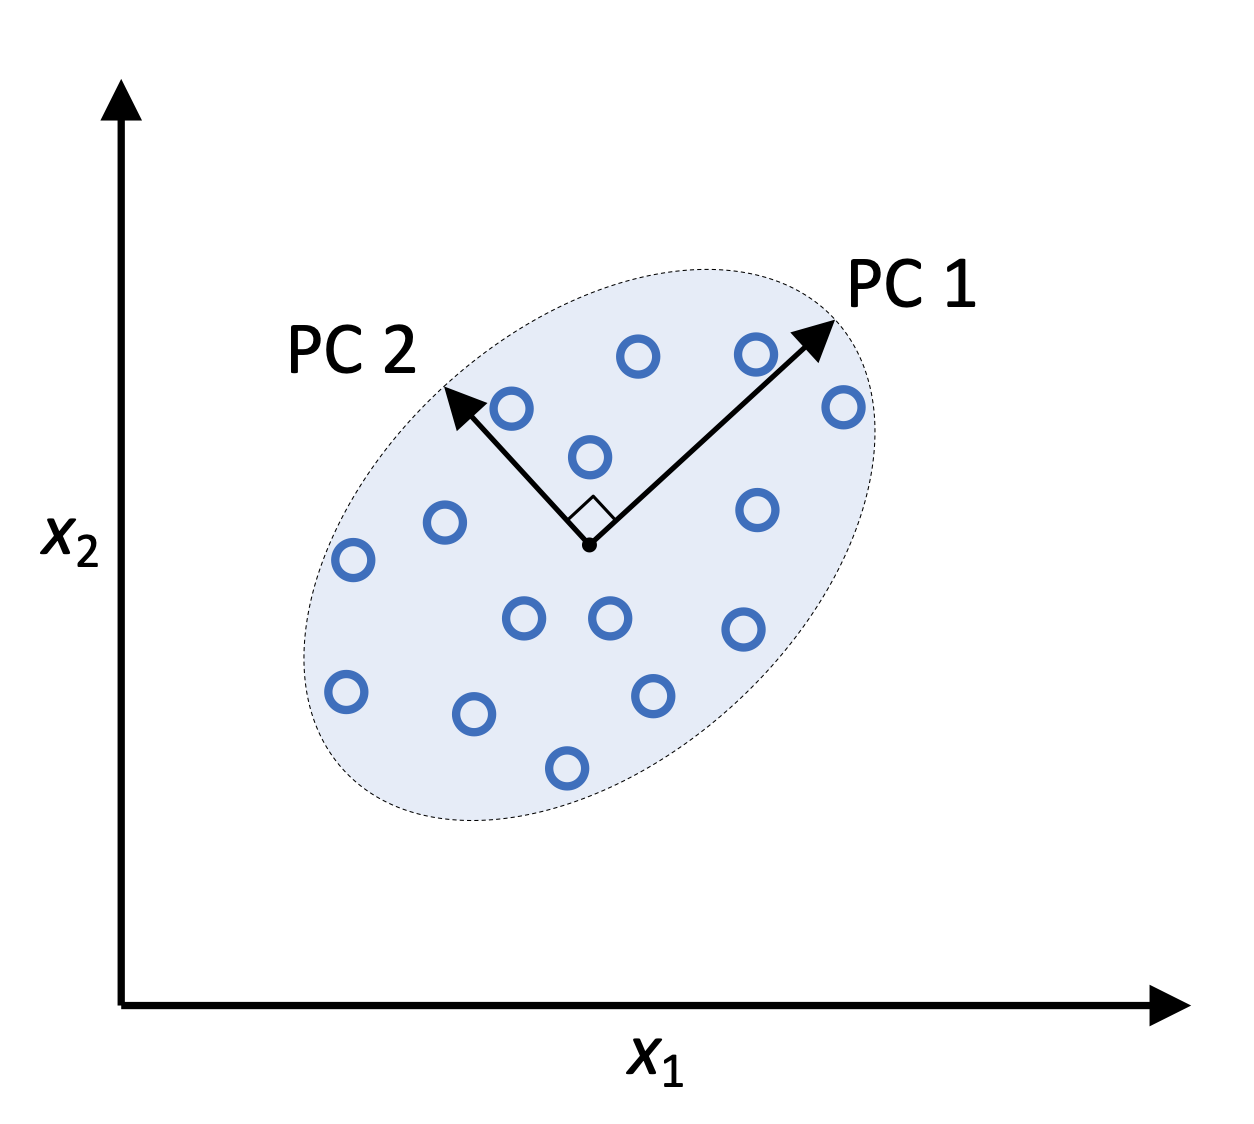

In [46]:
from IPython.display import Image

Image(filename='../Python-MachineLearning/Attached_images/Chapter5/figures/05_01.png', 
      width=450)

在上图中, $x_1$和$x_2$是原始特征轴(original feature axes), 同时`PC 1`和`PC 2`是主成分.

当我们使用PCA进行降维处理的时候, 会构建一个$d\times k$维度的转换矩阵$\mathbf{W}$， 利用它就可以将训练样本$x$的特征向量映射到一个新的$k$维特征子空间，该子空间的维度小于原始特征子空间维度$d$。例如：假设有一个特征向量$\boldsymbol{x}$,则：

$$\boldsymbol{x}=[x_1,x_2,...,x_d],\quad \boldsymbol{x}\in\mathbb{R}^d$$

它通过转换矩阵$\mathbf{W}$进行投影，其中$\mathbf{W}\in\mathbb{R}^{d\times k}$，如下：
$$\boldsymbol{x}\mathbf{W}=\boldsymbol{z}$$

在上式中，输出向量满足：
$$\mathbf{z}=[z_{1},z_{2},...,z_{k}],\quad\mathbf{z}\in\mathbb{R}^{k}$$

`需要注意的是，PCA方向对数据尺度高度敏感，因此在进行PCA之前需要进行特征标准化`。

#### 主成分分析的步骤

主成分分析的步骤可以总结如下：

* 对$d$维的待处理数据集进行标准化(Standardize)处理；
* 构建协方差矩阵(Construct the covariance matrix);
* 协方差矩阵分解(Decompose the Covariance matrix), 得到特征值和特征向量(eigenvectors and eigenvalues);
* 按降序对特征值进行排序，包括与其对应的特征向量；
* 选择$k$个最大特征值对应的特征向量，其中$k$是新的特征空间的维度，其满足($k\le d$);
* 利用"top" $k$个特征向量构建投影矩阵$\mathbf{W}$;
* 对$d$维的输入数据$\mathbf{X}$, 利用投影矩阵$\mathbf{W}$进行变换，得到$k$维特征子空间。

#### 利用Python实现主成分分析

In [47]:
# 载入数据.
import pandas as pd

df_wine = pd.read_csv('../Python-MachineLearning/Datasets//Wine_data/wine.data',
                      header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines', 'Proline']

df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [48]:
# 数据集拆分.
from sklearn.model_selection import train_test_split
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, stratify=y, 
                                                    random_state=0)

In [49]:
# 特征标准化.
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

协方差矩阵为对称方阵，存储了不同特征之间的成对协方差.对两个特征$x_j$和$x_k$,其计算过程如下：
$$\sigma_{jk}=\frac{1}{n-1}\sum_{i=1}^{n}\bigl(x_{j}^{(i)}-\mu_{j}\bigr)\bigl(x_{k}^{(i)}-\mu_{k}\bigr)$$

其中，$\mu_{j}$和$\mu_{k}$分别是特征$j$和$k$的样本均值。三个特征的协方差矩阵可以写为如下形式：
$$\Sigma=\begin{bmatrix}\sigma_1^2&\sigma_{12}&\sigma_{13}\\\sigma_{21}&\sigma_2^2&\sigma_{23}\\\sigma_{31}&\sigma_{32}&\sigma_3^2\end{bmatrix}$$

协方差矩阵的特征向量表示主成分(方差最大的方向)，而相应的特征值则定义为其大小。 在线形代数中，特征向量满足：
$$\Sigma\boldsymbol{v}=\lambda\boldsymbol{v}$$

其中，$\lambda$是一个标量形式的特征值。

In [50]:
# 构建协方差矩阵并计算特征值和特征向量.
import numpy as np

cov_mat = np.cov(X_train_std.T)
eigen_values, eigen_vecs  = np.linalg.eig(cov_mat)

print('Eigenvalues', eigen_values)

Eigenvalues [4.84274532 2.41602459 1.54845825 0.96120438 0.84166161 0.6620634
 0.51828472 0.34650377 0.3131368  0.10754642 0.21357215 0.15362835
 0.1808613 ]


#### 总方差和解释方差(Total and explained variance)

为了将数据集压缩到新的特征子空间来降低维度，所以仅需要选择包含大部分信息(variance)的特征向量子集(principal components). 特征值定义了特征向量的大小，因此需要按照降序对特征值进行排序，然后选择前$k$个.

具体地，首先绘制方差解释比例(variance explained ratio), 其定义如下：
$$\text{Explained variance ratio}=\frac{\lambda_j}{\sum_{j=1}^d\lambda_j}$$

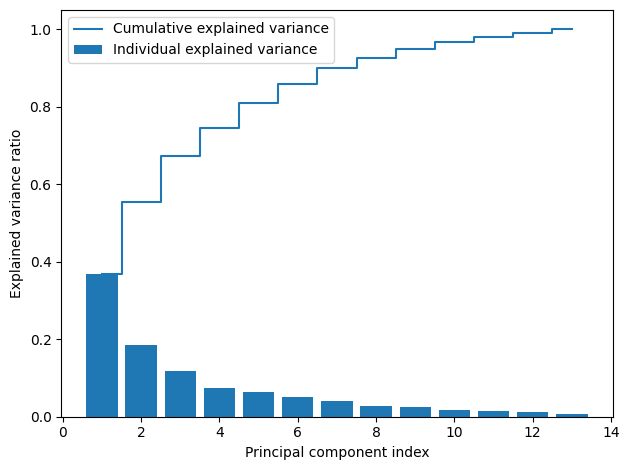

In [51]:
# 绘制方差解释比例(variance explained ratios).
tot = sum(eigen_values)
"""
特征值通常表示主成分分析(PCA)中每个主成分所解释的方差.
"""
var_exp = [(i / tot) for i in 
           sorted(eigen_values, reverse=True)]
"""
首先对每个特征值进行排序，然后计算每个主成分的解释方差比例(即每个特征值与总特征值的比值).
"""
cum_var_exp = np.cumsum(var_exp)
"""
使用numpy中的cumsum函数计算累积解释方差. cum_var_exp中的每个元素表示到当前主成分为止的总
解释方差比例.
"""

import matplotlib.pyplot as plt
plt.bar(range(1, 14), var_exp, align='center', 
        label='Individual explained variance')
"""
绘制一个条形图，表示每个主成分的单独解释方差比例.
"""
plt.step(range(1, 14), cum_var_exp, where='mid', 
         label='Cumulative explained variance')
"""
绘制一条阶梯图，表示累积解释方差. where='mid'确保阶梯的变化发生在每个区间的中间位置.
"""

plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

生成的图表表明，第一个主成分单独解释了大约40%的方差；此外，前两个主成分一共解释了数据集中近60%的方差.

#### 特征变换

上述过程已经将协方差矩阵分解为特征对(eigenpairs)，为完成特征空间映射，其余步骤如下：

* 选择$k$个最大特征值对应的特征向量，$k$是新特征空间的维度($k\le d$);
* 利用$k$个特征向量构建投影矩阵$\mathbf{W}$;
* 使用投影矩阵对输入数据集$\boldsymbol{X}$进行变换，得到$k$维特征子空间。

In [52]:
# 构建(eigenvalue, eigenvector)元组.
eigen_pairs = [(np.abs(eigen_values[i]), eigen_vecs[:, i])
               for i in range(len(eigen_values))]

# 对eigenpairs进行排序.
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

In [53]:
print(eigen_pairs[0])

(4.8427453156559, array([-0.13724218,  0.24724326, -0.02545159,  0.20694508, -0.15436582,
       -0.39376952, -0.41735106,  0.30572896, -0.30668347,  0.07554066,
       -0.32613263, -0.36861022, -0.29669651]))


接下来，收集与两个最大特征值相对应的两个特征向量，以捕获此数据集中约60%的方差。

In [54]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis], 
               eigen_pairs[1][1][:, np.newaxis]))

print('The projection matrix W: \n', w)

The projection matrix W: 
 [[-0.13724218  0.50303478]
 [ 0.24724326  0.16487119]
 [-0.02545159  0.24456476]
 [ 0.20694508 -0.11352904]
 [-0.15436582  0.28974518]
 [-0.39376952  0.05080104]
 [-0.41735106 -0.02287338]
 [ 0.30572896  0.09048885]
 [-0.30668347  0.00835233]
 [ 0.07554066  0.54977581]
 [-0.32613263 -0.20716433]
 [-0.36861022 -0.24902536]
 [-0.29669651  0.38022942]]


In [55]:
# 使用投影矩阵进行特征空间变换. x'=xW
X_train_std[0].dot(w)

array([2.38299011, 0.45458499])

In [56]:
# 推广到整个数据集.
X_train_pca = X_train_std.dot(w)

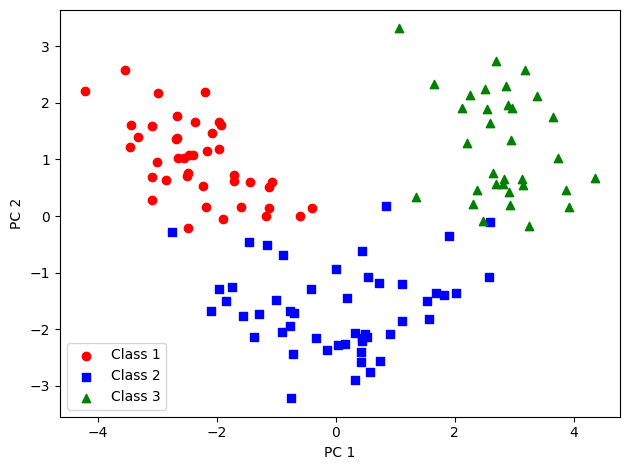

In [57]:
# 可视化变换后的数据集.
X_train_pca = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['o', 's', '^']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train == l, 0], 
                X_train_pca[y_train == l, 1], 
                c=c, label=f'Class {l}', marker=m)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('../Python-MachineLearning/Attached_images/Chapter5/figures/05_03.png', dpi=600)
plt.show()

In [58]:
X_train_pca[y_train == 1, 0]

array([-1.96578183, -2.53907598, -1.43010776, -3.00366211, -1.12276518,
       -1.58427878, -1.71438911, -2.07635784, -2.50372355, -2.19448402,
       -1.11739618, -1.71469178, -2.48581303, -2.38993219, -2.65169609,
       -1.16670455, -2.4858391 , -2.16575568, -2.66783112, -2.67324153,
       -2.36367378, -0.39171875, -2.98908845, -1.91822539, -1.06050503,
       -3.31185057, -2.23205085, -1.88961007, -3.08131761, -3.45716348,
       -3.43344371, -4.20642597, -0.60047516, -3.08276231, -3.07882055,
       -2.84838157, -2.46582558, -2.16983025, -2.66728229, -3.53223924,
       -1.96637688])

#### 使用Sklearn实现主成分分析

In [59]:
# 决策边界绘制函数.
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=f'Class {cl}', 
                    edgecolor='black')

d:\installation\Anaconda3\envs\pyml-book\lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


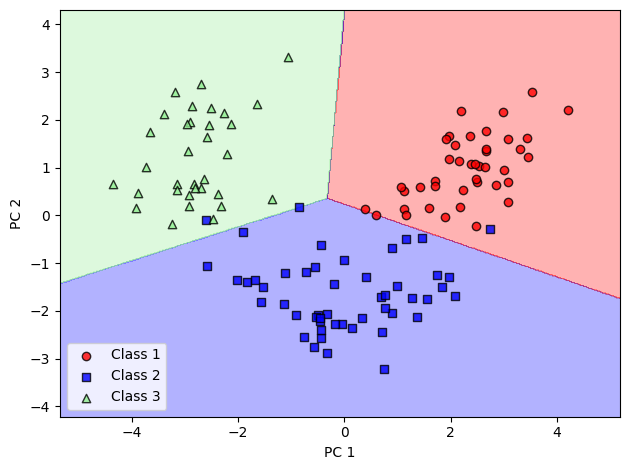

In [60]:
# 使用sklearn实现.
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

lr = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs')
pca = PCA(n_components=2)

# 降维处理.
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

# 模型拟合.
lr.fit(X_train_pca, y_train)
plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

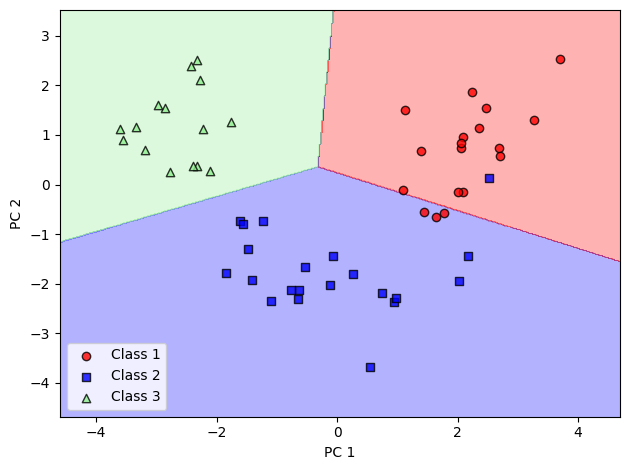

In [61]:
plot_decision_regions(X_test_pca, y_test, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

In [62]:
# 保留所有的主成分，通过设置n_components参数实现.
pca = PCA(n_components=None)
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([0.36951469, 0.18434927, 0.11815159, 0.07334252, 0.06422108,
       0.05051724, 0.03954654, 0.02643918, 0.02389319, 0.01629614,
       0.01380021, 0.01172226, 0.00820609])

#### 评估特征贡献

In [63]:
"""
每个原始特征对给定主成分的贡献，被称为loadings.  载荷可以通过特征向量与特征值的平方根来计算得到，然后
可以将结果解释为原始特征与主成分之间的相关性。
"""

# 计算13维载荷矩阵.
loadings = eigen_vecs * np.sqrt(eigen_values)

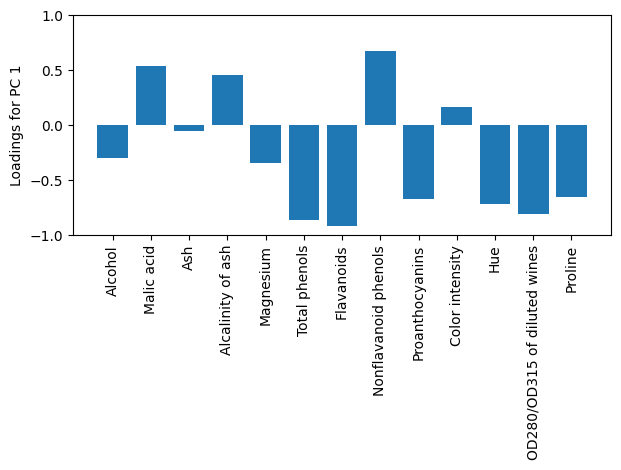

In [64]:
# 绘制第一个主成分的loadings.
# print(loadings.shape) # (13, 13)

fig, ax = plt.subplots()
ax.bar(range(13), loadings[:, 0], align='center')
ax.set_ylabel('Loadings for PC 1')
ax.set_xticks(range(13))
ax.set_xticklabels(df_wine.columns[1:], rotation=90)
plt.ylim([-1, 1])
plt.tight_layout()
plt.show()

In [65]:
# 从拟合的sklearn对象中获取loadings.
sklearn_loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

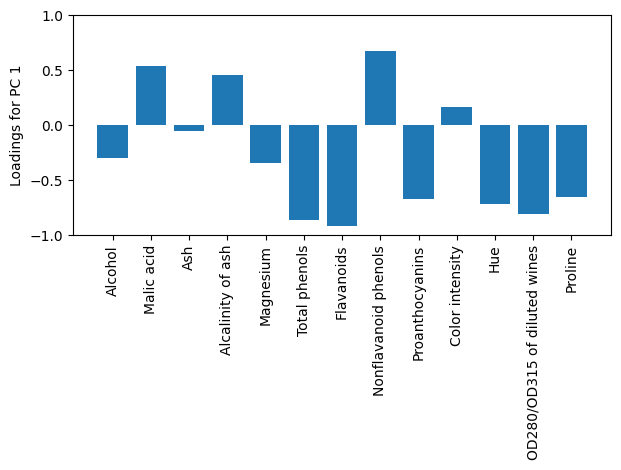

In [67]:
# 创建一个类似的条形图来对比.
fig, ax = plt.subplots()

ax.bar(range(13), - sklearn_loadings[:, 0], align='center')
ax.set_ylabel('Loadings for PC 1')
ax.set_xticks(range(13))
ax.set_xticklabels(df_wine.columns[1:], rotation=90)

plt.ylim([-1, 1])
plt.tight_layout()
plt.show()

#### 利用线形判别分析进行有监督数据压缩

LDA(Linear discriminant analysis)可以用作特征提取技术，以提高计算效率并降低非正则化模型中由于维数灾难而导致的过拟合程度。其原理与PCA非常相似，不同之处在于：PCA试图找到数据集中方差最大的正交分量轴，而LDA的目标是找到优化类别可分离性的特征子空间。

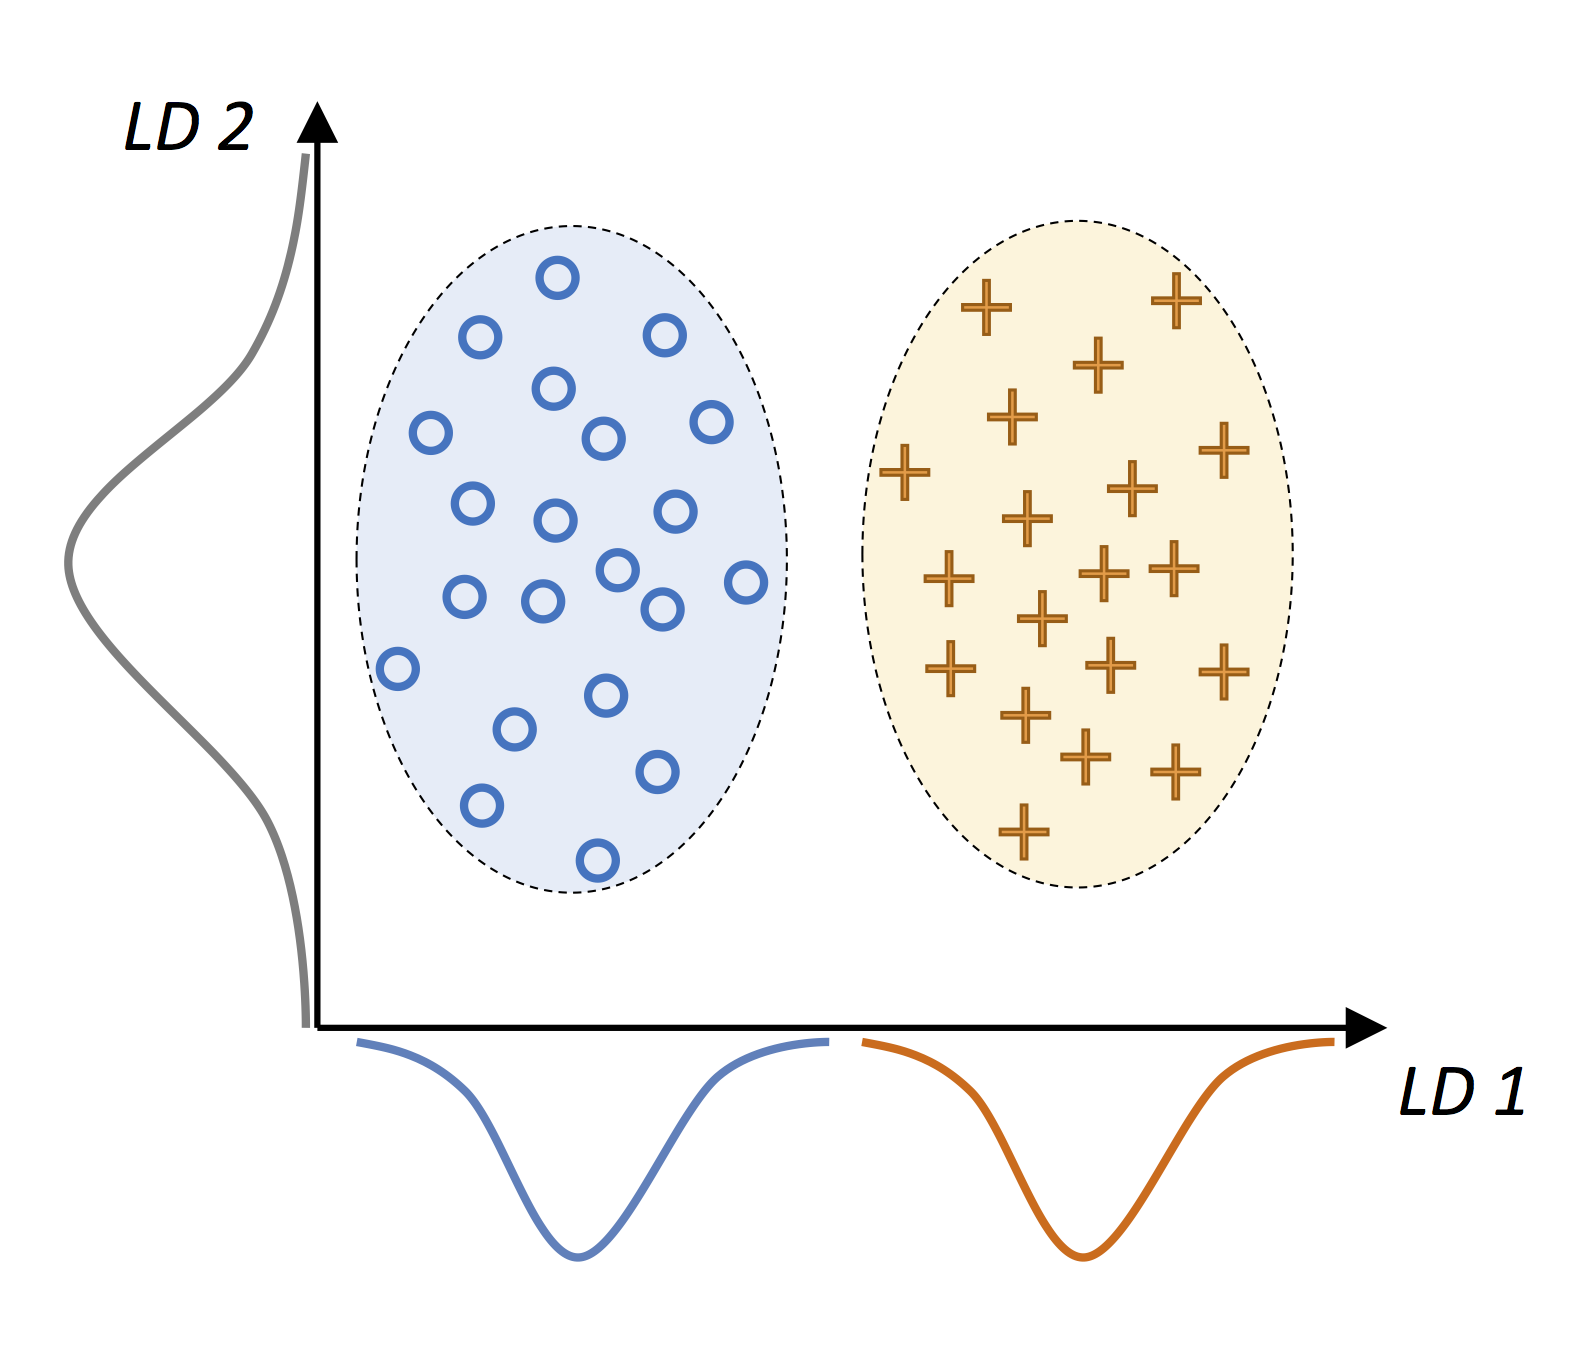

In [68]:
# 下图说明了LDA在处理二分类问题上的原理.
Image(filename='../Python-MachineLearning/Attached_images/Chapter5/figures/05_06.png', 
      width=450)

在上图中，x轴(LD 1)所示的线性判别式可以很好地将两个正态分布类别分开。 同时，虽然(LD 2)捕获了数据集中的大量方差，但它没有捕获任何类别判别信息(class-discriminatory).

`LDA中的一个假设是数据呈正态分布。此外，我们也假设各个类别有相同的协方差矩阵，并且训练样本在统计上彼此独立`。然而，即便这些假设中的一个或多个不满足，LDA仍然可以发挥作用。

#### 线形判别分析的内部工作原理

LDA的工作顺序如下：

* step1: 对$d$维的数据集进行标准化处理，$d$是特征个数；
* step2: 对于每个类别，计算$d$维的均值向量；
* step3: 构建类内和类间散度矩阵$S_B$和$S_w$;
* step4: 计算矩阵$S^{-1}_WS_B$的特征向量和对应的特征值；
* step5: 按照特征值大小对相应的特征向量进行排序;
* step6: 选择$k$个最大的特征值对应的特征向量，构成$d\times k$维的转换矩阵$\mathbf{W}$；
* step7: 利用转换矩阵将原始特征空间映射到新的特征子空间.

`需要注意的是，LDA会考虑类别标签的信息`.


#### 计算散度矩阵

在前面的步骤中，已经进行了标准化处理，所以这里继续计算均值向量. 每个均值向量$\boldsymbol{m}$存储了关于第$i$类的特征均值：
$$\boldsymbol{m}_i=\frac1{n_i}\sum_{x\in D_i}x_m$$

所以，在三个类别上，得到：

$$\boldsymbol{m}_i=\begin{bmatrix}\mu_{i,alcohol}\\\mu_{i,malic acid}\\\vdots\\\mu_{i,proline}\end{bmatrix}^T\quad i\in\{1,2,3\}$$

In [69]:
# 代码实现.
np.set_printoptions(precision=4)
mean_vecs = []

for label in range(1, 4):
    mean_vecs.append(np.mean(
        X_train_std[y_train == label], axis=0
    ))
    print(f'MV {label}: {mean_vecs[label - 1]}\n')

MV 1: [ 0.9066 -0.3497  0.3201 -0.7189  0.5056  0.8807  0.9589 -0.5516  0.5416
  0.2338  0.5897  0.6563  1.2075]

MV 2: [-0.8749 -0.2848 -0.3735  0.3157 -0.3848 -0.0433  0.0635 -0.0946  0.0703
 -0.8286  0.3144  0.3608 -0.7253]

MV 3: [ 0.1992  0.866   0.1682  0.4148 -0.0451 -1.0286 -1.2876  0.8287 -0.7795
  0.9649 -1.209  -1.3622 -0.4013]



#### 计算类内散度矩阵$S_w$.

$$\boldsymbol{S}_W=\sum_{i=1}^c\boldsymbol{S}_i$$
其中，$$\boldsymbol{S}_i=\sum_{{x}\in D_i}(\boldsymbol{x}-m_i)(\boldsymbol{x}-\boldsymbol{m}_i)^T$$

In [71]:
d = 13
S_W = np.zeros((d, d))

for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.zeros((d, d))
    for row in X_train_std[y_train == label]:
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)
        class_scatter += (row - mv).dot((row - mv).T)
    S_W += class_scatter

print('within-class scatter matrix: ' f'{S_W.shape[0]}x{S_W.shape[1]}')

within-class scatter matrix: 13x13


In [72]:
# 打印类别分布，可以看出类标签并没有满足均匀分布.
print('Class label distribution:', 
      np.bincount(y_train)[1:])

Class label distribution: [41 50 33]


因此，在将各个scatter矩阵$\boldsymbol{S}_i$相加为散度矩阵之前，首先对其进行缩放。如下公式，将散度矩阵除以类别-样本(class-examples)时，可以看出计算散度矩阵实际上与计算协方差矩阵相同，即协方差矩阵式散度矩阵的归一化版本.
$$\Sigma_{i}=\frac{1}{n_{i}}\boldsymbol{S}_{i}=\frac{1}{n_{i}}\sum_{x\in D_{i}}(\boldsymbol x-m_{i})(\boldsymbol x-m_{i})^{T}$$

In [73]:
# 计算缩放的类间散度矩阵.
d = 13
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train==label].T)
    S_W += class_scatter

print('Scaled within-class scatter matrix: 'f'{S_W.shape[0]} x {S_W.shape[1]}')

Scaled within-class scatter matrix: 13 x 13


#### 计算类间散度矩阵.

计算过程如下：$$\boldsymbol S_B=\sum_{i=1}^cn_i(\boldsymbol{m}_i-\boldsymbol{m})(\boldsymbol{m}_i-\boldsymbol{m})^T$$
其中，$\boldsymbol{m}$是计算的总体均值，包括所有$\boldsymbol{c}$个类别.

In [76]:
mean_overall = np.mean(X_train_std, axis=0)
mean_overall = mean_overall.reshape(d, 1)

d = 13
S_B = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):
    n = X_train_std[y_train == i+1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1)
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)

print('Between-Class scatter matrix: ' f'{S_B.shape[0]} x {S_B.shape[1]}')

Between-Class scatter matrix: 13 x 13


In [77]:
# 计算转换矩阵.
eigen_values, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

In [81]:
# 构建特征值和特征向量对.
eigen_pairs = [(np.abs(eigen_values[i]), eigen_vecs[:, i]) for i in range(len(eigen_values))]

eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)
print('Eigenvalues in descening order:\n')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

Eigenvalues in descening order:

349.6178089059939
172.76152218979385
4.6138298979609615e-14
2.842170943040401e-14
2.1547547231576004e-14
2.1547547231576004e-14
2.1321463669527416e-14
2.1321463669527416e-14
1.4639876994554242e-14
9.87835891156858e-15
6.9209749419683555e-15
6.9209749419683555e-15
3.795292302943713e-15


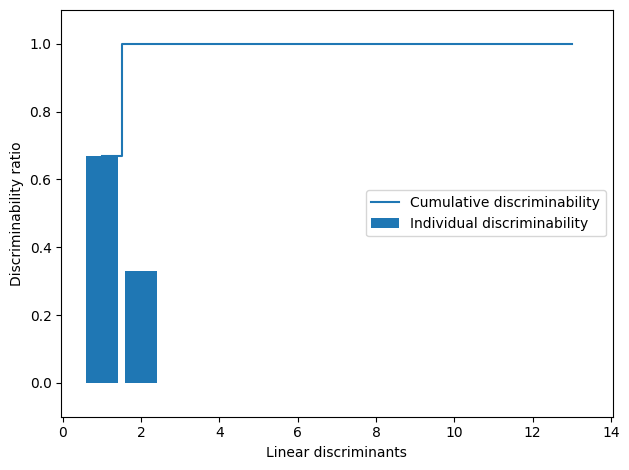

In [82]:
"""
为了度量线形判别(特征向量)捕获了多少的类判别信息，这里类似于PCA，将类判别信息称为判别度(discriminability).
"""

tot = sum(eigen_values.real)
discr = [(i / tot) for i in sorted(eigen_values.real, reverse=True)]
cum_discr = np.cumsum(discr)

plt.bar(range(1, 14), discr, align='center',
        label='Individual discriminability')
plt.step(range(1, 14), cum_discr, where='mid',
         label='Cumulative discriminability')
plt.ylabel('Discriminability ratio')
plt.xlabel('Linear discriminants')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.tight_layout()
plt.show()

如上图所示, 前两个线形判别就捕获了100%的有用信息。

In [83]:
# 将前两个最具有判别力的特征向量堆叠起来，构建转换矩阵.
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real,
              eigen_pairs[1][1][:, np.newaxis].real))
print('Matrix W:\n', w)

Matrix W:
 [[-0.1481 -0.4092]
 [ 0.0908 -0.1577]
 [-0.0168 -0.3537]
 [ 0.1484  0.3223]
 [-0.0163 -0.0817]
 [ 0.1913  0.0842]
 [-0.7338  0.2823]
 [-0.075  -0.0102]
 [ 0.0018  0.0907]
 [ 0.294  -0.2152]
 [-0.0328  0.2747]
 [-0.3547 -0.0124]
 [-0.3915 -0.5958]]


#### 特征子空间映射

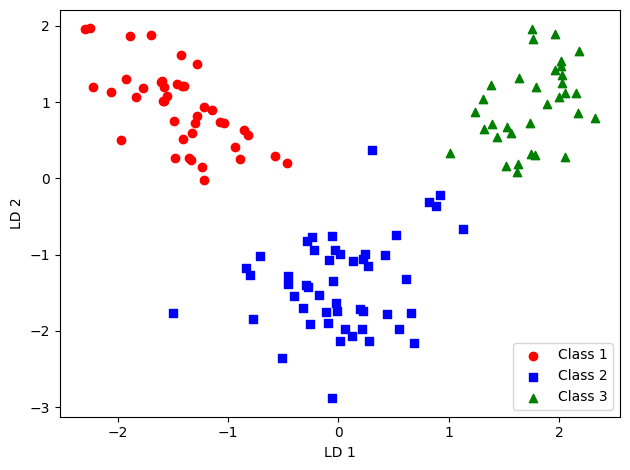

In [84]:
X_train_lda = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['o', 's', '^']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train == l, 0],
                X_train_lda[y_train == l, 1] * (-1),
                c=c, label=f'Class {l}', marker=m)

plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

#### 使用sklearn实现LDA

d:\installation\Anaconda3\envs\pyml-book\lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


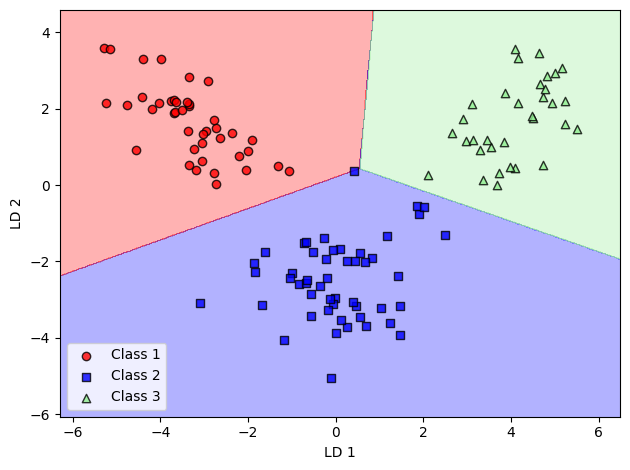

In [85]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs')
lr = lr.fit(X_train_lda, y_train)

plot_decision_regions(X_train_lda, y_train, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

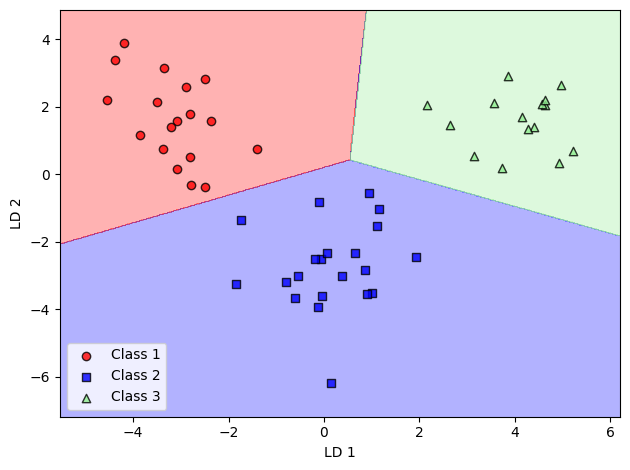

In [86]:
X_test_lda = lda.transform(X_test_std)

plot_decision_regions(X_test_lda, y_test, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

#### 非线性降维

一种典型代表技术是T-SNE(t-distributed stochastic neighbor embedding)。

非线性降维技术的开发和应用经常被称为流形学习。其中，流形(manifold)是嵌入高维空间的低纬拓扑空间。t-SNE 是根据高维（原始）特征空间中的成对距离对数据点进行建模。然后，它会在新的低维空间中找到成对距离的概率分布，该概率分布接近原始空间中成对距离的概率分布。或者换句话说，t-SNE 学习将数据点嵌入到低维空间中，从而保留原始空间中的成对距离。

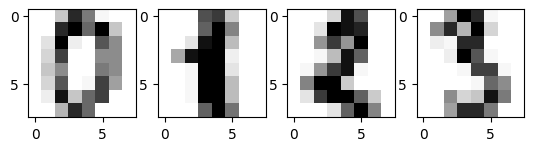

In [87]:
from sklearn.datasets import load_digits

digits = load_digits()
fig, ax = plt.subplots(1, 4)

for i in range(4):
    ax[i].imshow(digits.images[i], cmap='Greys')

plt.show()

In [88]:
digits.data.shape

(1797, 64)

In [89]:
y_digits = digits.target
X_digits = digits.data

In [90]:
from sklearn.manifold import TSNE


tsne = TSNE(n_components=2,
            init='pca',
            random_state=123)
X_digits_tsne = tsne.fit_transform(X_digits)

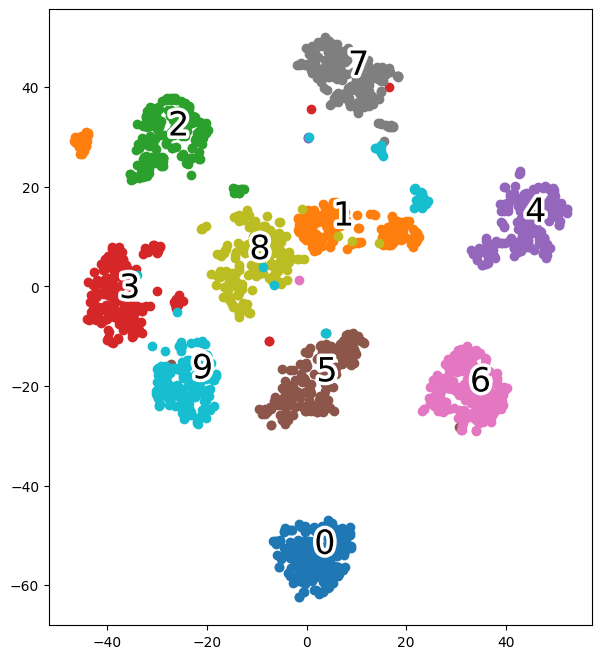

In [91]:
import matplotlib.patheffects as PathEffects # 允许在图中为文本添加效果, 例如轮廓.


def plot_projection(x, colors):
    
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal') # 纵横比相等.
    for i in range(10):
        plt.scatter(x[colors == i, 0],
                    x[colors == i, 1])

    for i in range(10):

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        
plot_projection(X_digits_tsne, y_digits)
plt.show()

#### 均匀流形近似和投影(Uniform manifold approximation and projection)

UMAP可以产生与T-SNE类似的结果，后者是无监督的。但前者通常更快并且可以用于投影新数据。[A scikit-learn compatible implementation of UMAP](https://umap-learn.readthedocs.io/en/latest/)。

使用 PCA，将数据投影到低维子空间，以最大化沿正交特征轴的方差，同时忽略类标签。与 PCA 相比，LDA 是一种监督降维技术，这意味着它考虑训练数据集中的类标签信息，以尝试最大化线性特征空间中的类可分性。最后，还介绍了 t-SNE，这是一种非线性特征提取技术，可用于在二维或三维中可视化数据。